In [1]:
import os
import os.path
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import sklearn_evaluation.plot as skplot
from sklearn.model_selection import learning_curve

import matplotlib.pyplot as plt

import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.densenet import DenseNet169,preprocess_input

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
imagedir = "Datasets/Detection/Byteplots"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:          Banker	Number of images: 1986
Label: 1	Family:          WinExe	Number of images: 1945
Processing images ...


/usr/local/lib/python3.5/dist-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (103265280 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
/usr/local/lib/python3.5/dist-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (110601216 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Images processed: 3931


In [4]:
X.shape

(3931, 224, 224, 3)

In [5]:
# Creating base_model
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = DenseNet169(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [6]:
print("Extracting bottleneck features from convolutional layers ...")
bnfeatures = base_model.predict(X)

Extracting bottleneck features from convolutional layers ...


In [7]:
bnfeatures.shape

(3931, 1, 1, 1664)

In [8]:
bnfeatures = np.reshape(bnfeatures,(bnfeatures.shape[0],-1))

In [9]:
bnfeatures.shape

(3931, 1664)

In [10]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 5  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)

In [11]:
# Training top_model
C_range = np.logspace(-2, 3, 6)
gamma_range = np.logspace(-8, 1, 10)
param_grid = dict(gamma=gamma_range, C=C_range)

top_model = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=skf, verbose=10, n_jobs=-1)
top_model.fit(bnfeatures,y)  # Training 

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] gamma=1e-08, C=0.01 .............................................
[CV] gamma=1e-08, C=0.01 .............................................
[CV] gamma=1e-08, C=0.01 .............................................
[CV] gamma=1e-08, C=0.01 .............................................
[CV] gamma=1e-08, C=0.01 .............................................
[CV] gamma=1e-07, C=0.01 .............................................
[CV] gamma=1e-07, C=0.01 .............................................
[CV] gamma=1e-07, C=0.01 .............................................
[CV] gamma=1e-07, C=0.01 .............................................
[CV] gamma=1e-07, C=0.01 .............................................
[CV] gamma=1e-06, C=0.01 .............................................
[CV] gamma=1e-06, C=0.01 .............................................
[CV] gamma=1e-06, C=0.01 .............................................
[CV] gamma=1e-0

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.8min


[CV] .............. gamma=1e-08, C=0.01, score=0.505089, total= 1.6min
[CV] gamma=0.001, C=0.01 .............................................
[CV] .............. gamma=1e-08, C=0.01, score=0.505089, total= 1.5min
[CV] gamma=0.001, C=0.01 .............................................
[CV] .............. gamma=1e-06, C=0.01, score=0.505089, total= 1.5min
[CV] gamma=0.001, C=0.01 .............................................
[CV] .............. gamma=1e-08, C=0.01, score=0.505718, total= 1.5min
[CV] gamma=0.001, C=0.01 .............................................
[CV] .............. gamma=1e-08, C=0.01, score=0.505089, total= 1.5min
[CV] gamma=0.01, C=0.01 ..............................................
[CV] .............. gamma=1e-08, C=0.01, score=0.505089, total= 1.6min
[CV] gamma=0.01, C=0.01 ..............................................
[CV] .............. gamma=1e-05, C=0.01, score=0.505718, total= 1.5min
[CV] gamma=0.01, C=0.01 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  2.9min


[CV] .............. gamma=1e-05, C=0.01, score=0.505089, total= 1.6min
[CV] gamma=0.1, C=0.01 ...............................................
[CV] .............. gamma=1e-07, C=0.01, score=0.505089, total= 1.6min
[CV] .............. gamma=1e-07, C=0.01, score=0.505089, total= 1.6min
[CV] gamma=1.0, C=0.01 ...............................................
[CV] gamma=1.0, C=0.01 ...............................................
[CV] ............. gamma=0.0001, C=0.01, score=0.653113, total= 1.6min
[CV] gamma=1.0, C=0.01 ...............................................
[CV] .............. gamma=1e-05, C=0.01, score=0.505089, total= 1.6min
[CV] gamma=1.0, C=0.01 ...............................................
[CV] ............. gamma=0.0001, C=0.01, score=0.659033, total= 1.6min
[CV] gamma=1.0, C=0.01 ...............................................
[CV] ............. gamma=0.0001, C=0.01, score=0.653944, total= 1.6min
[CV] gamma=10.0, C=0.01 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.9min


[CV] .............. gamma=0.001, C=0.01, score=0.875476, total= 1.1min
[CV] gamma=10.0, C=0.01 ..............................................
[CV] .............. gamma=0.001, C=0.01, score=0.868957, total= 1.1min
[CV] gamma=10.0, C=0.01 ..............................................
[CV] .............. gamma=0.001, C=0.01, score=0.890585, total= 1.1min
[CV] gamma=1e-08, C=0.1 ..............................................
[CV] .............. gamma=0.001, C=0.01, score=0.899491, total= 1.1min
[CV] gamma=1e-08, C=0.1 ..............................................
[CV] .............. gamma=0.001, C=0.01, score=0.903308, total= 1.1min
[CV] gamma=1e-08, C=0.1 ..............................................
[CV] ............. gamma=0.0001, C=0.01, score=0.652672, total= 1.6min
[CV] gamma=1e-08, C=0.1 ..............................................
[CV] ............... gamma=0.01, C=0.01, score=0.878018, total= 1.6min
[CV] gamma=1e-08, C=0.1 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  5.6min


[CV] ............... gamma=0.01, C=0.01, score=0.880407, total= 1.6min
[CV] gamma=1e-06, C=0.1 ..............................................
[CV] ................ gamma=1.0, C=0.01, score=0.505718, total= 1.5min
[CV] gamma=1e-06, C=0.1 ..............................................
[CV] ................ gamma=1.0, C=0.01, score=0.505089, total= 1.6min
[CV] gamma=1e-06, C=0.1 ..............................................
[CV] ................ gamma=1.0, C=0.01, score=0.505089, total= 1.5min
[CV] gamma=1e-05, C=0.1 ..............................................
[CV] ............... gamma=10.0, C=0.01, score=0.505089, total= 1.5min
[CV] gamma=1e-05, C=0.1 ..............................................
[CV] ............... gamma=0.01, C=0.01, score=0.866412, total= 1.6min
[CV] gamma=1e-05, C=0.1 ..............................................
[CV] ................ gamma=1.0, C=0.01, score=0.505089, total= 1.5min
[CV] gamma=1e-05, C=0.1 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  7.3min


[CV] ............... gamma=10.0, C=0.01, score=0.505089, total= 1.6min
[CV] gamma=0.0001, C=0.1 .............................................
[CV] ............... gamma=10.0, C=0.01, score=0.505089, total= 1.5min
[CV] gamma=0.001, C=0.1 ..............................................
[CV] ............... gamma=1e-08, C=0.1, score=0.505718, total= 1.6min
[CV] gamma=0.001, C=0.1 ..............................................
[CV] ............... gamma=1e-08, C=0.1, score=0.505089, total= 1.6min
[CV] gamma=0.001, C=0.1 ..............................................
[CV] ............... gamma=1e-08, C=0.1, score=0.505089, total= 1.6min
[CV] gamma=0.001, C=0.1 ..............................................
[CV] ............... gamma=1e-07, C=0.1, score=0.505089, total= 1.5min
[CV] gamma=0.001, C=0.1 ..............................................
[CV] ............... gamma=1e-07, C=0.1, score=0.505089, total= 1.5min
[CV] gamma=0.01, C=0.1 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:  8.5min


[CV] ............... gamma=1e-08, C=0.1, score=0.505089, total= 1.6min
[CV] gamma=0.1, C=0.1 ................................................
[CV] ............... gamma=1e-05, C=0.1, score=0.664122, total= 1.6min
[CV] gamma=1.0, C=0.1 ................................................
[CV] ............... gamma=1e-06, C=0.1, score=0.505089, total= 1.6min
[CV] gamma=1.0, C=0.1 ................................................
[CV] ............... gamma=1e-07, C=0.1, score=0.505089, total= 1.6min
[CV] gamma=1.0, C=0.1 ................................................
[CV] ............... gamma=1e-05, C=0.1, score=0.683206, total= 1.6min
[CV] gamma=1.0, C=0.1 ................................................
[CV] ............... gamma=1e-05, C=0.1, score=0.690840, total= 1.6min
[CV] gamma=1.0, C=0.1 ................................................
[CV] ............... gamma=1e-05, C=0.1, score=0.678117, total= 1.6min
[CV] gamma=10.0, C=0.1 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:  9.4min


[CV] ................ gamma=0.01, C=0.1, score=0.880559, total=  57.7s
[CV] gamma=1e-08, C=1.0 ..............................................
[CV] ................ gamma=0.01, C=0.1, score=0.900763, total=  58.1s
[CV] ................ gamma=0.01, C=0.1, score=0.881679, total=  58.2s
[CV] gamma=1e-07, C=1.0 ..............................................
[CV] gamma=1e-07, C=1.0 ..............................................
[CV] ................ gamma=0.01, C=0.1, score=0.872774, total=  58.0s
[CV] gamma=1e-07, C=1.0 ..............................................
[CV] ................ gamma=0.01, C=0.1, score=0.914758, total=  59.7s
[CV] gamma=1e-07, C=1.0 ..............................................
[CV] ................. gamma=0.1, C=0.1, score=0.511450, total= 1.5min
[CV] gamma=1e-07, C=1.0 ..............................................
[CV] ................. gamma=0.1, C=0.1, score=0.538168, total= 1.5min
[CV] gamma=1e-06, C=1.0 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 11.3min


[CV] ................. gamma=1.0, C=0.1, score=0.507634, total= 1.5min
[CV] gamma=0.0001, C=1.0 .............................................
[CV] ................ gamma=10.0, C=0.1, score=0.505089, total= 1.5min
[CV] gamma=0.0001, C=1.0 .............................................
[CV] ................ gamma=10.0, C=0.1, score=0.505089, total= 1.5min
[CV] gamma=0.0001, C=1.0 .............................................
[CV] ............... gamma=1e-08, C=1.0, score=0.505718, total= 1.5min
[CV] gamma=0.0001, C=1.0 .............................................
[CV] ............... gamma=1e-08, C=1.0, score=0.505089, total= 1.6min
[CV] gamma=0.001, C=1.0 ..............................................
[CV] ............... gamma=1e-08, C=1.0, score=0.505089, total= 1.5min
[CV] gamma=0.001, C=1.0 ..............................................
[CV] .............. gamma=0.0001, C=1.0, score=0.926302, total=  29.9s
[CV] gamma=0.001, C=1.0 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed: 12.8min


[CV] ............... gamma=0.001, C=1.0, score=0.946565, total=  21.7s
[CV] gamma=0.1, C=1.0 ................................................
[CV] ............... gamma=0.001, C=1.0, score=0.942748, total=  20.9s
[CV] gamma=0.1, C=1.0 ................................................
[CV] ............... gamma=1e-05, C=1.0, score=0.899491, total=  51.3s
[CV] gamma=1.0, C=1.0 ................................................
[CV] ............... gamma=0.001, C=1.0, score=0.973282, total=  22.8s
[CV] gamma=1.0, C=1.0 ................................................
[CV] ............... gamma=1e-05, C=1.0, score=0.907125, total=  52.4s
[CV] gamma=1.0, C=1.0 ................................................
[CV] ............... gamma=1e-07, C=1.0, score=0.505089, total= 1.5min
[CV] gamma=1.0, C=1.0 ................................................
[CV] ............... gamma=1e-07, C=1.0, score=0.505718, total= 1.5min
[CV] gamma=1.0, C=1.0 ................................................
[CV] .

[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed: 14.0min


[CV] ............... gamma=1e-06, C=1.0, score=0.683206, total= 1.6min
[CV] gamma=1e-07, C=10.0 .............................................
[CV] ................ gamma=0.01, C=1.0, score=0.919847, total=  50.8s
[CV] gamma=1e-07, C=10.0 .............................................
[CV] ................. gamma=0.1, C=1.0, score=0.704835, total= 1.5min
[CV] gamma=1e-07, C=10.0 .............................................
[CV] ................. gamma=0.1, C=1.0, score=0.746819, total= 1.5min
[CV] gamma=1e-06, C=10.0 .............................................
[CV] ................. gamma=0.1, C=1.0, score=0.722999, total= 1.5min
[CV] gamma=1e-06, C=10.0 .............................................
[CV] ................. gamma=1.0, C=1.0, score=0.570521, total= 1.5min
[CV] gamma=1e-06, C=10.0 .............................................
[CV] ................. gamma=0.1, C=1.0, score=0.729008, total= 1.5min
[CV] gamma=1e-06, C=10.0 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed: 16.4min


[CV] .............. gamma=1e-05, C=10.0, score=0.916031, total=  29.8s
[CV] gamma=0.001, C=10.0 .............................................
[CV] ................ gamma=10.0, C=1.0, score=0.534351, total= 1.5min
[CV] gamma=0.001, C=10.0 .............................................
[CV] .............. gamma=1e-05, C=10.0, score=0.924936, total=  29.8s
[CV] gamma=0.001, C=10.0 .............................................
[CV] .............. gamma=1e-05, C=10.0, score=0.949109, total=  32.3s
[CV] gamma=0.001, C=10.0 .............................................
[CV] .............. gamma=1e-05, C=10.0, score=0.928753, total=  30.0s
[CV] gamma=0.01, C=10.0 ..............................................
[CV] .............. gamma=1e-08, C=10.0, score=0.505718, total= 1.5min
[CV] gamma=0.01, C=10.0 ..............................................
[CV] .............. gamma=1e-08, C=10.0, score=0.505089, total= 1.5min
[CV] gamma=0.01, C=10.0 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 17.1min


[CV] .............. gamma=0.001, C=10.0, score=0.983461, total=  21.4s
[CV] gamma=10.0, C=10.0 ..............................................
[CV] .............. gamma=1e-06, C=10.0, score=0.900763, total=  51.6s
[CV] gamma=10.0, C=10.0 ..............................................
[CV] .............. gamma=1e-06, C=10.0, score=0.899491, total=  53.0s
[CV] .............. gamma=1e-06, C=10.0, score=0.907125, total=  53.9s
[CV] gamma=10.0, C=10.0 ..............................................
[CV] gamma=1e-08, C=100.0 ............................................
[CV] .............. gamma=0.001, C=10.0, score=0.958015, total=  20.1s
[CV] gamma=1e-08, C=100.0 ............................................
[CV] .............. gamma=0.001, C=10.0, score=0.960560, total=  20.7s
[CV] gamma=1e-08, C=100.0 ............................................
[CV] .............. gamma=1e-07, C=10.0, score=0.683206, total= 1.6min
[CV] gamma=1e-08, C=100.0 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed: 19.8min


[CV] ............... gamma=10.0, C=10.0, score=0.529860, total= 1.5min
[CV] gamma=1e-05, C=100.0 ............................................
[CV] ................ gamma=1.0, C=10.0, score=0.594148, total= 1.6min
[CV] gamma=1e-05, C=100.0 ............................................
[CV] ............... gamma=10.0, C=10.0, score=0.539440, total= 1.5min
[CV] gamma=0.0001, C=100.0 ...........................................
[CV] ................ gamma=1.0, C=10.0, score=0.587786, total= 1.6min
[CV] gamma=0.0001, C=100.0 ...........................................
[CV] ............... gamma=10.0, C=10.0, score=0.543257, total= 1.6min
[CV] gamma=0.0001, C=100.0 ...........................................
[CV] ............. gamma=1e-08, C=100.0, score=0.684478, total= 1.5min
[CV] gamma=0.0001, C=100.0 ...........................................
[CV] ............... gamma=10.0, C=10.0, score=0.535623, total= 1.6min
[CV] gamma=0.0001, C=100.0 ...........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed: 20.5min


[CV] ............. gamma=1e-05, C=100.0, score=0.944020, total=  20.4s
[CV] gamma=1.0, C=100.0 ..............................................
[CV] ............. gamma=1e-05, C=100.0, score=0.944020, total=  20.8s
[CV] gamma=1.0, C=100.0 ..............................................
[CV] ............ gamma=0.0001, C=100.0, score=0.958015, total=  18.4s
[CV] gamma=1.0, C=100.0 ..............................................
[CV] ............. gamma=1e-06, C=100.0, score=0.949109, total=  31.7s
[CV] gamma=1.0, C=100.0 ..............................................
[CV] ............. gamma=1e-06, C=100.0, score=0.928753, total=  30.4s
[CV] gamma=10.0, C=100.0 .............................................
[CV] ............. gamma=0.001, C=100.0, score=0.978399, total=  21.6s
[CV] gamma=10.0, C=100.0 .............................................
[CV] ............. gamma=0.001, C=100.0, score=0.964377, total=  21.2s
[CV] gamma=10.0, C=100.0 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed: 23.0min


[CV] ............ gamma=1e-07, C=1000.0, score=0.916031, total=  30.0s
[CV] gamma=1e-06, C=1000.0 ...........................................
[CV] ............... gamma=0.1, C=100.0, score=0.755725, total= 1.5min
[CV] gamma=1e-05, C=1000.0 ...........................................
[CV] ............... gamma=0.1, C=100.0, score=0.698473, total= 1.5min
[CV] gamma=1e-05, C=1000.0 ...........................................
[CV] ............ gamma=1e-07, C=1000.0, score=0.949109, total=  31.0s
[CV] gamma=1e-05, C=1000.0 ...........................................
[CV] ............... gamma=0.1, C=100.0, score=0.729352, total= 1.6min
[CV] gamma=1e-05, C=1000.0 ...........................................
[CV] ............ gamma=1e-07, C=1000.0, score=0.924936, total=  30.3s
[CV] gamma=1e-05, C=1000.0 ...........................................
[CV] ............... gamma=0.1, C=100.0, score=0.715013, total= 1.6min
[CV] gamma=0.0001, C=1000.0 ..........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 284 out of 300 | elapsed: 25.1min remaining:  1.4min


[CV] ............. gamma=0.01, C=1000.0, score=0.933842, total= 1.1min
[CV] .............. gamma=0.1, C=1000.0, score=0.729352, total= 1.3min
[CV] .............. gamma=0.1, C=1000.0, score=0.715013, total= 1.4min
[CV] ............. gamma=10.0, C=1000.0, score=0.539440, total= 1.2min
[CV] .............. gamma=1.0, C=1000.0, score=0.594148, total= 1.3min
[CV] ............. gamma=10.0, C=1000.0, score=0.526718, total= 1.3min
[CV] .............. gamma=0.1, C=1000.0, score=0.755725, total= 1.3min
[CV] ............. gamma=10.0, C=1000.0, score=0.535623, total= 1.2min
[CV] .............. gamma=1.0, C=1000.0, score=0.587786, total= 1.3min
[CV] .............. gamma=1.0, C=1000.0, score=0.587786, total= 1.3min
[CV] .............. gamma=0.1, C=1000.0, score=0.736641, total= 1.3min
[CV] .............. gamma=0.1, C=1000.0, score=0.698473, total= 1.3min
[CV] ............. gamma=10.0, C=1000.0, score=0.529860, total= 1.3min
[CV] ............. gamma=10.0, C=1000.0, score=0.543257, total= 1.3min
[CV] .

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 25.9min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'gamma': array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01]), 'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [12]:
top_model.cv_results_

{'mean_fit_time': array([73.67770586, 76.53885808, 76.50729032, 77.62255387, 77.57245989,
        52.21139255, 76.21122794, 74.79565148, 74.41669083, 73.93097262,
        75.13805861, 74.83365583, 75.27524943, 75.84767785, 42.71111336,
        27.45144963, 46.74208121, 74.03978181, 74.19058418, 73.42980571,
        74.18937259, 73.03764181, 73.68397102, 41.21750126, 24.58210144,
        17.60438771, 40.61300726, 73.266467  , 72.24964719, 72.67324457,
        73.50368314, 74.24573317, 42.47726369, 24.5066803 , 16.7184803 ,
        16.94577398, 59.95074873, 75.48740878, 74.10148635, 74.10503798,
        75.28632488, 41.61757922, 24.76248736, 16.9585475 , 15.08891363,
        17.2873529 , 59.69125814, 74.90954628, 74.23995085, 73.72418151,
        42.00510511, 24.59859638, 16.89849825, 14.98746133, 15.09529886,
        17.15437651, 55.02080231, 66.03874393, 64.74492331, 61.90882316]),
 'mean_score_time': array([19.17808237, 18.73159299, 18.72634344, 18.74152226, 18.71352224,
        12.70

In [13]:
top_model.grid_scores_

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.50521, std: 0.00025, params: {'gamma': 1e-08, 'C': 0.01},
 mean: 0.50521, std: 0.00025, params: {'gamma': 1e-07, 'C': 0.01},
 mean: 0.50521, std: 0.00025, params: {'gamma': 1e-06, 'C': 0.01},
 mean: 0.50521, std: 0.00025, params: {'gamma': 1e-05, 'C': 0.01},
 mean: 0.65123, std: 0.00728, params: {'gamma': 0.0001, 'C': 0.01},
 mean: 0.88756, std: 0.01335, params: {'gamma': 0.001, 'C': 0.01},
 mean: 0.88349, std: 0.01337, params: {'gamma': 0.01, 'C': 0.01},
 mean: 0.50521, std: 0.00025, params: {'gamma': 0.1, 'C': 0.01},
 mean: 0.50521, std: 0.00025, params: {'gamma': 1.0, 'C': 0.01},
 mean: 0.50521, std: 0.00025, params: {'gamma': 10.0, 'C': 0.01},
 mean: 0.50521, std: 0.00025, params: {'gamma': 1e-08, 'C': 0.1},
 mean: 0.50521, std: 0.00025, params: {'gamma': 1e-07, 'C': 0.1},
 mean: 0.50521, std: 0.00025, params: {'gamma': 1e-06, 'C': 0.1},
 mean: 0.68074, std: 0.00934, params: {'gamma': 1e-05, 'C': 0.1},
 mean: 0.89163, std: 0.01168, params: {'gamma': 0.0001, 'C': 0.1},
 mea

In [14]:
print("Best parameters: %s - score: %0.4f" % (top_model.best_params_, top_model.best_score_))

Best parameters: {'gamma': 0.001, 'C': 10.0} - score: 0.9697


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


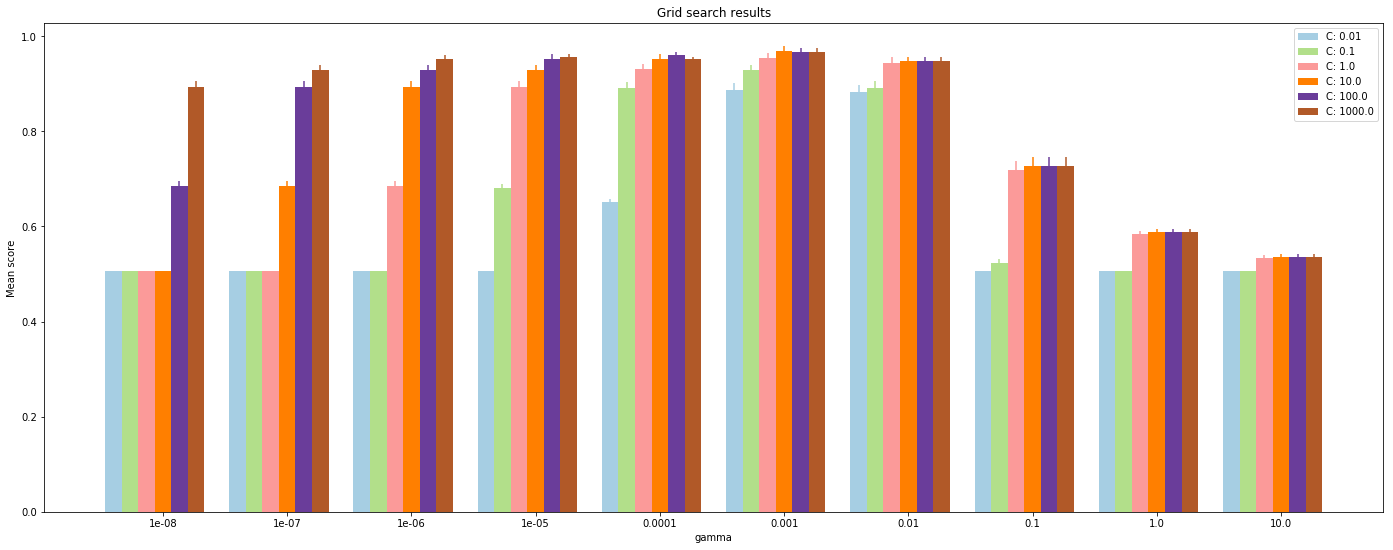

In [15]:
plt.rcParams['image.cmap'] = 'Paired'
skplot.grid_search(top_model.grid_scores_, change='gamma', kind='bar')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()